In [33]:
import pandas as pd

# this is data where the genres have been cleaned
users_info = pd.read_csv('postprocessed_user_info_with_genre.csv.zip', compression='zip', index_col=0)
print(users_info.head())
# print(users_info.columns)
print('\n\ndone importing...')

done importing..


shape of users_info before:  (893909, 11)
unique genres before removal:  3115
-----------------------------
shape of users_info after key removal:  (646206, 11)
length of users_info after:  646206


<AxesSubplot:>

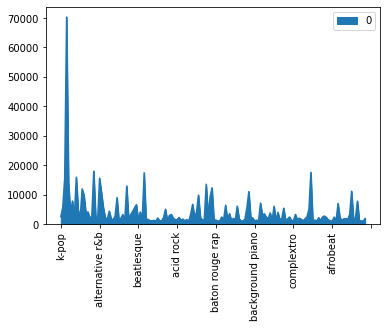

In [34]:
# time to make a threshold to eliminate several containers
from collections import Counter

a = list(users_info['genre'].copy())
letter_counts = Counter(a)
print('shape of users_info before: ', users_info.shape)
print('unique genres before removal: ',len(list(letter_counts)))
delete = set()
for key in letter_counts:
    if(letter_counts[key] < 1000):
        delete.add(key)
for key in delete:
    del letter_counts[key]

# delete the genres with small frequency
indexes = []
for i,g in enumerate(users_info['genre']):
    if(g in delete):
        indexes.append(i)
users_info.drop(users_info.index[indexes], axis=0, inplace=True)
print('-----------------------------')
print('unique genres after removal: ',len(list(letter_counts)))
print('shape of users_info after key removal: ', users_info.shape)
print('length of users_info after: ',sum(letter_counts.values()))
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='area',rot=90)

In [35]:
# stats
s = [(key,val) for key,val in letter_counts.items()]
s.sort(key=lambda x: x[1])
print('min: ', s[0])
print('mean:', sum(letter_counts.values())/len(letter_counts))
print('median: ', s[len(s)//2])
t = Counter(letter_counts.values())
m = -1
mTuple = []
# highest frequency
for k,v in t.items():
    if(v > m):
        m = v
        mTuple = [(k,v)]
    elif(v == m):
        mTuple.append((k,v))
print('mode: %d with freq. of %d'%(mTuple[0][0], mTuple[0][1]))
print('max: ', s[-1])

min:  ('acoustic blues', 1008)
mean: 4089.9113924050635
median:  ('funk', 2080)
mode: 1509 with freq. of 2
max:  ('dance pop', 70354)


In [37]:
firstQuartile = s[round(0.25*len(s))][1]
print(firstQuartile)
thirdQuartile = s[round(0.75*len(s))][1]
print(thirdQuartile)
IQR = thirdQuartile - firstQuartile
lowerBound = firstQuartile - 1.5*IQR
upperBound = thirdQuartile + 1.5*IQR
print(lowerBound)
print(upperBound)
outliers = []
for k,v in s:
    if(v > upperBound or v < lowerBound):
        outliers.append((k,v))
print('Number of outliers: ', len(outliers))
print('Number of Inbound numbers:', len(letter_counts)-len(outliers))
print('Outliers:\n',outliers)

1397
4111
-2674.0
8182.0
Number of outliers:  19
Number of Inbound numbers: 139
Outliers:
 [('alternative dance', 8991), ('latin', 9147), ('alternative hip hop', 9713), ('big room', 9832), ('hip hop', 10616), ('ccm', 11040), ('anthem worship', 11161), ('alternative rock', 11957), ('atl hip hop', 12307), ('alternative metal', 12924), ('edm', 13520), ('pop', 14058), ('alt z', 15451), ('alternative r&b', 15571), ('adult standards', 15923), ('album rock', 17422), ('christian hip hop', 17557), ('chillhop', 17951), ('dance pop', 70354)]


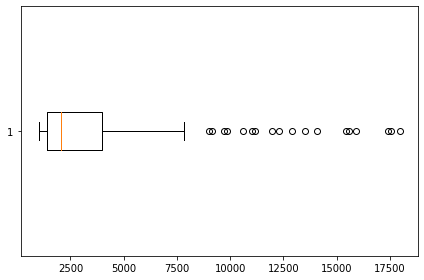

In [45]:
import matplotlib.pyplot as plt
data = list(letter_counts.values())
data.pop(data.index(70354)) # remove huge outlier called 'dance pop'
plt.boxplot(data,vert=False)
plt.tight_layout()
plt.show()

In [70]:
data = {} # key=genre, value=dataframe with that genre


print(type(users_info))
print(len(users_info))
for j in range(len(users_info)):
    row = users_info.iloc[j,:].copy()
    if(row['genre'] in letter_counts and row['genre'] not in data):
        data[row['genre']] = [row.tolist()]
    elif(row['genre'] in letter_counts and row['genre'] in data):
        data[row['genre']].append(row.tolist())

keys = list(data.keys())
for key in keys: # turn them all into dataframes
    data[key] = pd.DataFrame(data[key], columns=list(users_info.columns))
for key in keys[:5]: # print info of the first five
    print('genre-type: ',data[key]['genre'][0],' and length: ', len(data[key]['genre']),'\n',data[key].head())


<class 'pandas.core.frame.DataFrame'>
646206
genre-type:  k-pop  and length:  2535 
                      user_id      artist  genre  ...  loudness  speechiness    tempo
0  4ura3429lz6lq6xs5itaoqiyi     HINAPIA  k-pop  ...    -2.373       0.0626   89.994
1  4ura3429lz6lq6xs5itaoqiyi    CHUNG HA  k-pop  ...    -2.526       0.0445  101.850
2  4ura3429lz6lq6xs5itaoqiyi  Red Velvet  k-pop  ...    -3.229       0.0317  150.059
3  4ura3429lz6lq6xs5itaoqiyi    (G)I-DLE  k-pop  ...    -3.315       0.0648   92.037
4  4ura3429lz6lq6xs5itaoqiyi    (G)I-DLE  k-pop  ...    -3.139       0.0362  120.021

[5 rows x 11 columns]
genre-type:  electropop  and length:  5674 
                      user_id              artist  ... speechiness    tempo
0  4ura3429lz6lq6xs5itaoqiyi       Billie Eilish  ...      0.0482  120.033
1  4ura3429lz6lq6xs5itaoqiyi          Kreayshawn  ...      0.0683   77.508
2                 1263232932  The Japanese House  ...      0.0286   94.054
3                 1263232932         

In [130]:
import numpy as np
import scipy.linalg as la
# using mahalanobis for multivariate outlier detection
def mahalanobis(x=None, data=None, inv_covmat=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if np.all(inv_covmat == None):
        cov = np.cov(data.values.T)
        inv_covmat = la.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    if(len(x.shape) == 1):
        return mahal
    else:
        return mahal.diagonal()

In [131]:
# data now is ready to be analyzed seperately
from collections import defaultdict
from scipy.stats import chi2


del_data_indexes = defaultdict(list)

# numerical columns
num_columns = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo']
newLength = 0
for key in data.keys():
    mhList = []
    # for data analysis
    cov = np.cov(data[key][num_columns].values.T)
    inv_covmat = la.inv(cov)
    for i in range(len(data[key])):
        row = data[key].iloc[i,:]
        mh = mahalanobis(x=row[num_columns], data=data[key][num_columns], inv_covmat=inv_covmat)
        mhList.append(mh)
    data[key]['mahala'] = mhList
    #chi^2 value: critical value at a 0.01 significance level and 2 degrees of freedom
    data[key]['p_value'] = 1 - chi2.cdf(data[key]['mahala'], 2)
    print('for key=%s, original rows=%d ==> removed rows=%d'%(key,len(data[key]), len(data[key].loc[data[key].p_value < 0.01])))
    data[key] = data[key].loc[data[key].p_value >= 0.01] # must be above this chi^2
    newLength += len(data[key])


for key=k-pop, original rows=1903 ==> removed rows=690
for key=electropop, original rows=3985 ==> removed rows=1338
for key=alt z, original rows=11229 ==> removed rows=3653
for key=dance pop, original rows=70354 ==> removed rows=20580
for key=pop, original rows=14058 ==> removed rows=4138
for key=canadian pop, original rows=3465 ==> removed rows=1002
for key=lo-fi beats, original rows=7839 ==> removed rows=2220
for key=chill r&b, original rows=2621 ==> removed rows=640
for key=adult standards, original rows=15923 ==> removed rows=4467
for key=acoustic pop, original rows=4788 ==> removed rows=1280
for key=neo mellow, original rows=2071 ==> removed rows=549
for key=alternative rock, original rows=11957 ==> removed rows=3424
for key=alternative hip hop, original rows=9713 ==> removed rows=2920
for key=indie rock, original rows=3374 ==> removed rows=905
for key=art pop, original rows=4131 ==> removed rows=1147
for key=ambient, original rows=1927 ==> removed rows=530
for key=bedroom pop, or

In [142]:
print('Original length: ', len(users_info))
print('New Length after mahalanobis outlier removal: ', newLength)

Original length:  646206
New Length after mahalanobis outlier removal:  456873


In [143]:
# normalize the data
norm = {'popularity': 100, 'loudness': 60, 'tempo': 200} # 200 for tempo because of edm type music with faster beats
for key in data.keys():
    for attr in norm:
        data[key][attr] = data[key][attr] / norm[attr] # normalize each attribute

In [144]:
# get cluster centers
cluster_centers = {}

for key in data.keys():
    cluster_centers[key] = np.mean(data[key][num_columns]).tolist()

In [145]:
# combine all data
all_data = pd.concat([data[k] for k in data.keys()]) # join all data
all_data = all_data.sample(frac=1).reset_index(drop=True) # shuffle data and reset index


In [ ]:
threshold = round(len(all_data)*0.8)

# train
x_train = all_data[num_columns].iloc[:threshold,:]
y_train = all_data['genre'].iloc[:threshold,:]
# test
x_test = all_data[num_columns].iloc[threshold:,:]
y_test = all_data['genre'].iloc[threshold:,:]

# def getAccuracy(centroids):
#     accuracy = 0
#     for i in range(len(x_test)):
#         minDist = float('inf')
#         row = x_test.iloc[i,:]
#         for center in centroids:
#             distance = np.linalg.norm(np.array(row) - np.array(center))
#             if(distance > minDist):
#                 minDist = 

In [154]:
# make true labels
keys = {}
nextVal = 0
true_labels = []
for i in range(len(all_data)):
    g = str(all_data.loc[i,['genre']][0])
    # print(g)
    if g not in keys:
        keys[g] = nextVal
        nextVal += 1
    true_labels.append(keys[g])
all_data['true_labels'] = true_labels

In [160]:
#this is line seperator
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

In [161]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_data[num_columns].values)

all_data['pca-one'] = pca_result[:,0]
all_data['pca-two'] = pca_result[:,1]
all_data['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4804907  0.32300985 0.09859109]


# new starting point due to slow runtime....

In [168]:
# # export data
# print('starting to export data...')
# all_data.to_csv('all_clustering_data.csv.zip', compression='zip')
# print('done exporting!')

# import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

all_data = pd.read_csv('all_clustering_data.csv.zip', compression='zip')
print('done importing!')
true_labels = all_data['true_labels']
cols = ['pca-one','pca-two','pca-three']

starting to export data...


In [163]:
# find averages for each genre
sumKeys = {} # key=GENRE, value=(sum,count)
for i in range(len(all_data)):
    row = all_data[cols].iloc[i,:].tolist()
    g = all_data.loc[i,['genre']][0]
    if(g not in sumKeys):
        sumKeys[g] = [np.array(row),1]
    else:
        sumKeys[g][0] += np.array(row) # element wise addition
        sumKeys[g][1] += 1
    if(i % 1000==0):
        print('at row: ', i)
averages = [sumKeys[k][0]/sumKeys[k][1] for k in sumKeys.keys()]
print(averages)

KeyboardInterrupt: 

In [ ]:
print(type(averages[0]))

In [ ]:
k_means_kwargs = {
    'init': nd.array(averages), 
    'n_init':10, 
    'max_iter':300, 
    'random_state':42
}

k = len(sumKeys.keys()) # unique centers
# run K Means
print('Running KMEANS:')
kmeans = KMeans(n_clusters=k, **k_means_kwargs)
kmeans.fit(all_data[cols])
print('lowest SSE: ', kmeans.inertia_)
print('silhouette score: ', silhouette_score(all_data[cols], kmeans.labels_, metric='euclidean',))
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
print('Adjusted Rand Index: ', ari_kmeans)
all_data['labels_graph'] = kmeans.labels_



# PLOT THIS BAD BOY


#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(kmeans.labels_)

#plotting the results:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in u_labels:
    ax.scatter(all_data['pca-one'].loc[all_data['labels_graph'] == i], all_data['pca-two'].loc[all_data['labels_graph'] == i], all_data['pca-three'].loc[all_data['labels_graph'] == i], label=i)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s = 80, color = 'red', marker='x')
ax.legend()
plt.show()

In [ ]:
print('Running DBSCAN:')
dbscan = DBSCAN(eps=0.25) # maximum distance between two samples
dbscan.fit(all_data[cols])
print('silhouette score: ', silhouette_score(all_data[cols], dbscan.labels_, metric='euclidean'))
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)
print('Adjusted Rand Index: ', ari_dbscan)
all_data['labels_graph'] = dbscan.labels_



#Getting the Centroids
centroids = dbscan.cluster_centers_
u_labels = np.unique(dbscan.labels_)

#plotting the results:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in u_labels:
    ax.scatter(all_data['pca-one'].loc[all_data['labels_graph'] == i], all_data['pca-two'].loc[all_data['labels_graph'] == i], all_data['pca-three'].loc[all_data['labels_graph'] == i], label=i)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s = 80, color = 'red', marker='x')
ax.legend()
plt.show()

### The rest is optional, not really necessary...Pehaps just for ARI and other metrics

In [1]:
# import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


all_data = pd.read_csv('all_clustering_data.csv.zip', compression='zip')
print('done importing!')
true_labels = all_data['true_labels']

num_columns = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo']

done importing!


In [3]:
# find averages for each genre
cluster_centers = {} # key=GENRE, value=(sum,count)
for i in range(len(all_data)):
    row = all_data[num_columns].iloc[i,:].to_numpy()
    g = all_data.loc[i,['genre']][0]
    if(g not in cluster_centers):
        cluster_centers[g] = [row,1]
    else:
        cluster_centers[g][0] += row # element wise addition
        cluster_centers[g][1] += 1
    if(i % 1000==0):
        print('at row: ', i)

at row:  0
at row:  1000
at row:  2000
at row:  3000
at row:  4000
at row:  5000
at row:  6000
at row:  7000
at row:  8000
at row:  9000
at row:  10000
at row:  11000
at row:  12000
at row:  13000
at row:  14000
at row:  15000
at row:  16000
at row:  17000
at row:  18000
at row:  19000
at row:  20000
at row:  21000
at row:  22000
at row:  23000
at row:  24000
at row:  25000
at row:  26000
at row:  27000
at row:  28000
at row:  29000
at row:  30000
at row:  31000
at row:  32000
at row:  33000
at row:  34000
at row:  35000
at row:  36000
at row:  37000
at row:  38000
at row:  39000
at row:  40000
at row:  41000
at row:  42000
at row:  43000
at row:  44000
at row:  45000
at row:  46000
at row:  47000
at row:  48000
at row:  49000
at row:  50000
at row:  51000
at row:  52000
at row:  53000
at row:  54000
at row:  55000
at row:  56000
at row:  57000
at row:  58000
at row:  59000
at row:  60000
at row:  61000
at row:  62000
at row:  63000
at row:  64000
at row:  65000
at row:  66000
at row: 

KeyboardInterrupt: 

In [2]:
# from kneed import KneeLocator
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score


scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_data[num_columns]) # makes mean of 0 and stdev of 1
# scaled_features = df_subset[feat_cols] # normalized

In [ ]:
centers = [cluster_centers[k][0]/cluster_centers[k][1] for k in cluster_centers.keys()]

k_means_kwargs = {
    'init':np.array(centers), 
    'n_init':10, 
    'max_iter':300, 
    'random_state':42
}

k = len(cluster_centers.keys()) # unique centers
# run K Means
print('Running KMEANS:')
kmeans = KMeans(n_clusters=k, **k_means_kwargs)
kmeans.fit(scaled_features)
print('lowest SSE: ', kmeans.inertia_)
new_centers = kmeans.cluster_centers_
print('silhouette score: ', silhouette_score(scaled_features, kmeans.labels_, metric='euclidean',))
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_)
print('Adjusted Rand Index: ', ari_kmeans)


In [ ]:
print('Running DBSCAN:')
dbscan = DBSCAN(eps=0.3)
dbscan.fit(scaled_features)
print('silhouette score: ', silhouette_score(scaled_features, dbscan.labels_, metric='euclidean'))
ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_)
print('Adjusted Rand Index: ', ari_dbscan)